In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from safetensors.torch import save_model, load_model


In [2]:
batch_size = 256

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Pad((2, 2, 2, 2)),
    transforms.Normalize((.0,), (1.0,))
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


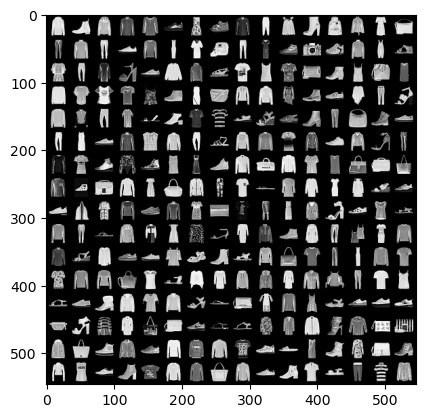

In [4]:
def imshow(img):
    plt.imshow(img.cpu().permute(1, 2, 0).numpy())
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images, nrow=16))

In [5]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 2, 1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 64, 3, 2, 1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(64, 128, 3, 2, 1)
        self.relu3 = nn.ReLU()
        self.flatten = nn.Flatten()
        self.mean = nn.Linear(128 * 4 * 4, 2)
        self.logvar = nn.Linear(128 * 4 * 4, 2)
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.flatten(x)
        mean = self.mean(x)
        logvar = self.logvar(x)
        return mean, logvar


In [6]:
encoder = Encoder().cuda()
summary(encoder, (1, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 16, 16]          320
├─ReLU: 1-2                              [-1, 32, 16, 16]          --
├─Conv2d: 1-3                            [-1, 64, 8, 8]            18,496
├─ReLU: 1-4                              [-1, 64, 8, 8]            --
├─Conv2d: 1-5                            [-1, 128, 4, 4]           73,856
├─ReLU: 1-6                              [-1, 128, 4, 4]           --
├─Flatten: 1-7                           [-1, 2048]                --
├─Linear: 1-8                            [-1, 2]                   4,098
├─Linear: 1-9                            [-1, 2]                   4,098
Total params: 100,868
Trainable params: 100,868
Non-trainable params: 0
Total mult-adds (M): 2.44
Input size (MB): 0.00
Forward/backward pass size (MB): 0.11
Params size (MB): 0.38
Estimated Total Size (MB): 0.50


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 16, 16]          320
├─ReLU: 1-2                              [-1, 32, 16, 16]          --
├─Conv2d: 1-3                            [-1, 64, 8, 8]            18,496
├─ReLU: 1-4                              [-1, 64, 8, 8]            --
├─Conv2d: 1-5                            [-1, 128, 4, 4]           73,856
├─ReLU: 1-6                              [-1, 128, 4, 4]           --
├─Flatten: 1-7                           [-1, 2048]                --
├─Linear: 1-8                            [-1, 2]                   4,098
├─Linear: 1-9                            [-1, 2]                   4,098
Total params: 100,868
Trainable params: 100,868
Non-trainable params: 0
Total mult-adds (M): 2.44
Input size (MB): 0.00
Forward/backward pass size (MB): 0.11
Params size (MB): 0.38
Estimated Total Size (MB): 0.50

In [7]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()        
        self.fc = nn.Linear(2, 2048)
        self.unflatten = nn.Unflatten(1, (128, 4, 4))
        self.convt1 = nn.ConvTranspose2d(128, 128, 3, 2, 1, 1)
        self.relu1 = nn.ReLU()
        self.convt2 = nn.ConvTranspose2d(128, 64, 3, 2, 1, 1)
        self.relu2 = nn.ReLU()
        self.convt3 = nn.ConvTranspose2d(64, 32, 3, 2, 1, 1)
        self.relu3 = nn.ReLU()
        self.conv = nn.Conv2d(32, 1, 3, 1, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.fc(x)
        x = self.unflatten(x)
        x = self.convt1(x)
        x = self.relu1(x)
        x = self.convt2(x)
        x = self.relu2(x)
        x = self.convt3(x)
        x = self.relu3(x)
        x = self.conv(x)
        x = self.sigmoid(x)
        return x

In [8]:
decoder = Decoder().cuda()
summary(decoder, (2,))

Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 2048]                6,144
├─Unflatten: 1-2                         [-1, 128, 4, 4]           --
├─ConvTranspose2d: 1-3                   [-1, 128, 8, 8]           147,584
├─ReLU: 1-4                              [-1, 128, 8, 8]           --
├─ConvTranspose2d: 1-5                   [-1, 64, 16, 16]          73,792
├─ReLU: 1-6                              [-1, 64, 16, 16]          --
├─ConvTranspose2d: 1-7                   [-1, 32, 32, 32]          18,464
├─ReLU: 1-8                              [-1, 32, 32, 32]          --
├─Conv2d: 1-9                            [-1, 1, 32, 32]           289
├─Sigmoid: 1-10                          [-1, 1, 32, 32]           --
Total params: 246,273
Trainable params: 246,273
Non-trainable params: 0
Total mult-adds (M): 47.48
Input size (MB): 0.00
Forward/backward pass size (MB): 0.46
Params size (MB): 0.94
Estimated Total Size (MB):

Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 2048]                6,144
├─Unflatten: 1-2                         [-1, 128, 4, 4]           --
├─ConvTranspose2d: 1-3                   [-1, 128, 8, 8]           147,584
├─ReLU: 1-4                              [-1, 128, 8, 8]           --
├─ConvTranspose2d: 1-5                   [-1, 64, 16, 16]          73,792
├─ReLU: 1-6                              [-1, 64, 16, 16]          --
├─ConvTranspose2d: 1-7                   [-1, 32, 32, 32]          18,464
├─ReLU: 1-8                              [-1, 32, 32, 32]          --
├─Conv2d: 1-9                            [-1, 1, 32, 32]           289
├─Sigmoid: 1-10                          [-1, 1, 32, 32]           --
Total params: 246,273
Trainable params: 246,273
Non-trainable params: 0
Total mult-adds (M): 47.48
Input size (MB): 0.00
Forward/backward pass size (MB): 0.46
Params size (MB): 0.94
Estimated Total Size (MB):

In [9]:
class Vae(nn.Module):
    def __init__(self):
        super(Vae, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def forward(self, x):
        mean, logvar = self.encoder(x)
        z = self.reparameterize(mean, logvar)
        x = self.decoder(z)
        return x, mean, logvar


In [10]:
model = Vae().cuda()
summary(model, (1, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
├─Encoder: 1-1                           [-1, 2]                   --
|    └─Conv2d: 2-1                       [-1, 32, 16, 16]          320
|    └─ReLU: 2-2                         [-1, 32, 16, 16]          --
|    └─Conv2d: 2-3                       [-1, 64, 8, 8]            18,496
|    └─ReLU: 2-4                         [-1, 64, 8, 8]            --
|    └─Conv2d: 2-5                       [-1, 128, 4, 4]           73,856
|    └─ReLU: 2-6                         [-1, 128, 4, 4]           --
|    └─Flatten: 2-7                      [-1, 2048]                --
|    └─Linear: 2-8                       [-1, 2]                   4,098
|    └─Linear: 2-9                       [-1, 2]                   4,098
├─Decoder: 1-2                           [-1, 1, 32, 32]           --
|    └─Linear: 2-10                      [-1, 2048]                6,144
|    └─Unflatten: 2-11                   [-1, 128, 4, 4]           

Layer (type:depth-idx)                   Output Shape              Param #
├─Encoder: 1-1                           [-1, 2]                   --
|    └─Conv2d: 2-1                       [-1, 32, 16, 16]          320
|    └─ReLU: 2-2                         [-1, 32, 16, 16]          --
|    └─Conv2d: 2-3                       [-1, 64, 8, 8]            18,496
|    └─ReLU: 2-4                         [-1, 64, 8, 8]            --
|    └─Conv2d: 2-5                       [-1, 128, 4, 4]           73,856
|    └─ReLU: 2-6                         [-1, 128, 4, 4]           --
|    └─Flatten: 2-7                      [-1, 2048]                --
|    └─Linear: 2-8                       [-1, 2]                   4,098
|    └─Linear: 2-9                       [-1, 2]                   4,098
├─Decoder: 1-2                           [-1, 1, 32, 32]           --
|    └─Linear: 2-10                      [-1, 2048]                6,144
|    └─Unflatten: 2-11                   [-1, 128, 4, 4]           

In [11]:
def loss_function(y, x, mean, logvar):
    bce_loss = F.binary_cross_entropy(y, x, reduction='sum')
    
    # KL divergence
    kld_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    
    return bce_loss + kld_loss, bce_loss, kld_loss
optimizer = optim.Adam(model.parameters(), lr=0.0001)
writer = SummaryWriter()

In [12]:
num_epochs = 5

for epoch in range(num_epochs):
    train_loss = 0
    batch_idx = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.cuda(), labels.cuda()    
        y, mean, logvar = model(imgs)
        total_loss, bce_loss, kld_loss = loss_function(y, imgs, mean, logvar)

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        train_loss += total_loss.item()
        writer.add_scalar('Total Loss', total_loss.item(), batch_idx)
        writer.add_scalar('BCE Loss', bce_loss.item(), batch_idx)
        writer.add_scalar('KLD Loss', kld_loss.item(), batch_idx)
        batch_idx += 1

    avg_loss = train_loss / len(train_loader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')
writer.close()

Epoch [1/5], Loss: 464.1007
Epoch [2/5], Loss: 313.0575
Epoch [3/5], Loss: 286.7351
Epoch [4/5], Loss: 281.9247
Epoch [5/5], Loss: 278.2774


In [13]:
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
test_x, test_label = next(iter(test_loader))
test_x = test_x.cuda()
with torch.no_grad():
    test_y, mean, logvar = model(test_x)

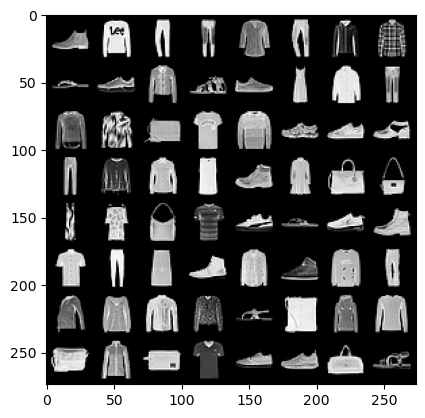

In [14]:
imshow(torchvision.utils.make_grid(test_x[:64]))

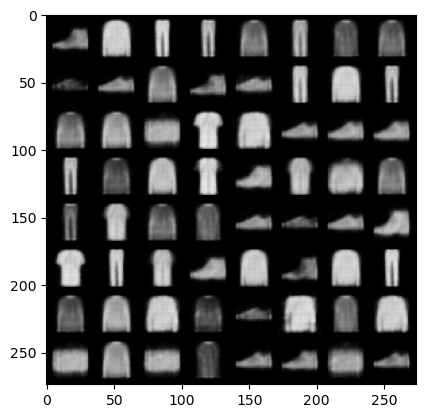

In [15]:
imshow(torchvision.utils.make_grid(test_y[:64]))

In [16]:
with torch.no_grad():
    mean, logvar = model.encoder(test_x)
    z = model.reparameterize(mean, logvar).cpu()

In [17]:
z

tensor([[-0.9322,  1.8877],
        [ 0.4323,  0.2052],
        [ 2.7299,  0.2141],
        ...,
        [ 0.9385,  0.6564],
        [ 2.6637,  0.4021],
        [-0.2898,  1.8960]])

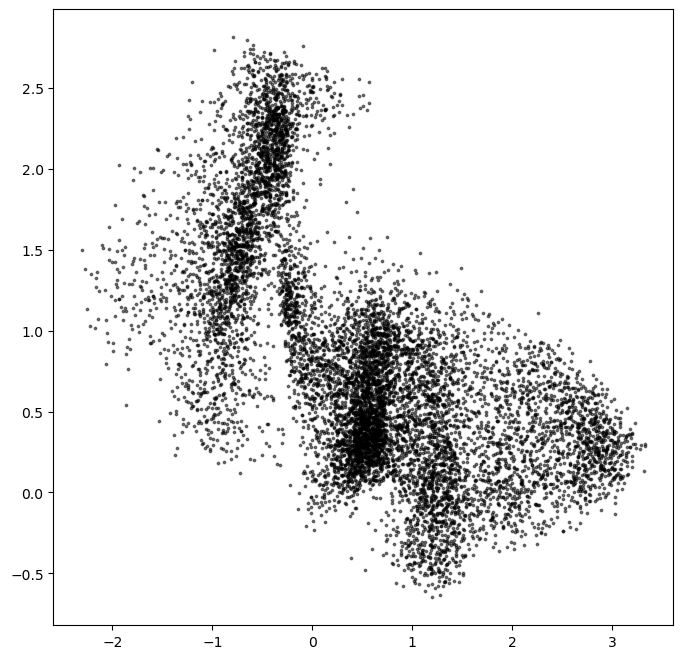

In [18]:
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=3)
plt.show()

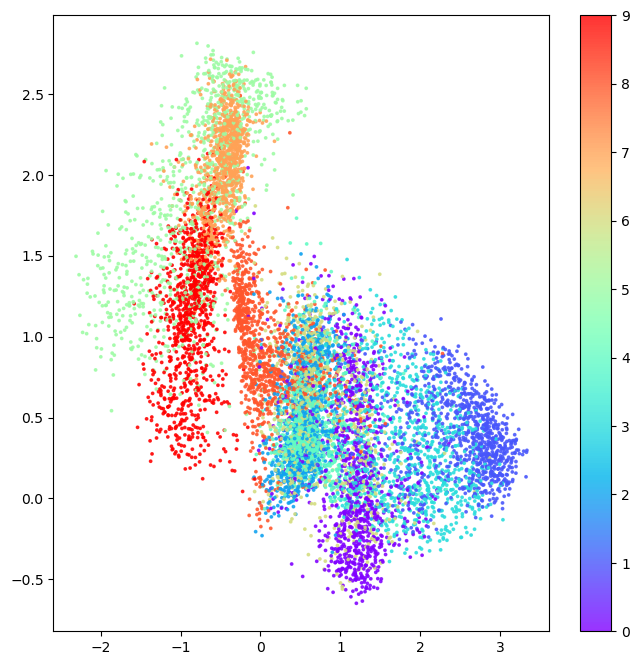

In [19]:
figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    z[:, 0],
    z[:, 1],
    cmap="rainbow",
    c=test_label,
    alpha=0.8,
    s=3,
)
plt.colorbar()
plt.show()

In [20]:
import torch
import torch.distributions as dist

# Define the normal distribution with mean 0 and standard deviation 1
normal_dist = dist.Normal(loc=0.0, scale=1.0)

# Compute the CDF for a given value, e.g., x = 1.0
p = normal_dist.cdf(z)


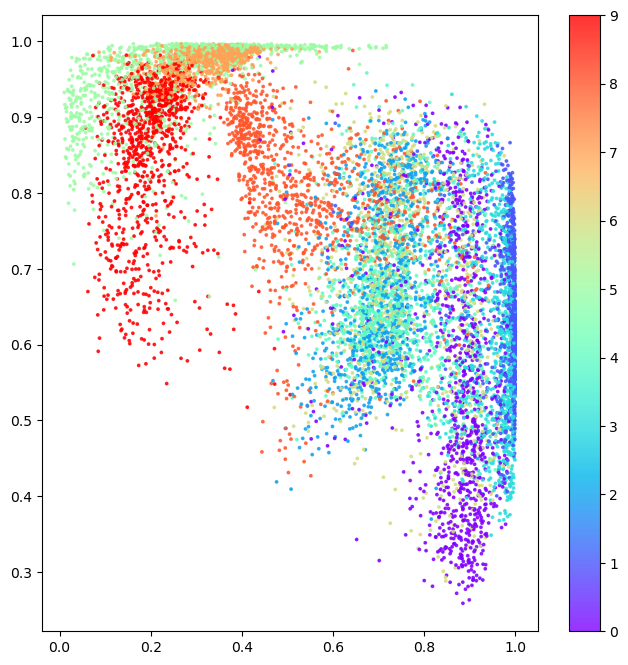

In [21]:
figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    p[:, 0],
    p[:, 1],
    cmap="rainbow",
    c=test_label,
    alpha=0.8,
    s=3,
)
plt.colorbar()
plt.show()

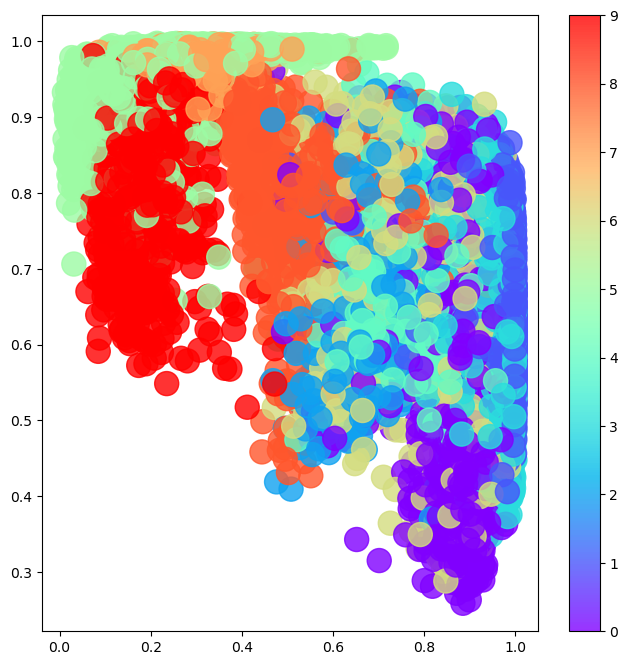

In [22]:
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    p[:, 0],
    p[:, 1],
    cmap="rainbow",
    c=test_label,
    alpha=0.8,
    s=300,
)
plt.colorbar()
plt.show()

In [23]:
grid_size = 16

x = torch.linspace(min(p[:, 0]), max(p[:, 0]), grid_size)
y = torch.linspace(max(p[:, 1]), min(p[:, 1]), grid_size)
xv, yv = torch.meshgrid(x, y, indexing='ij')
xv = xv.flatten()
yv = yv.flatten()
grid = torch.stack((xv, yv), dim=1)


In [24]:
with torch.no_grad():
    reconstructions = model.decoder(grid.cuda()).cpu()

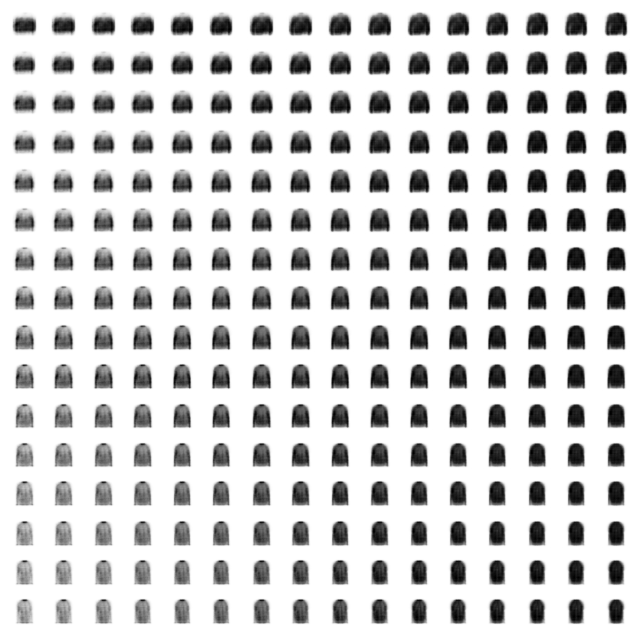

In [25]:
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i].squeeze(), cmap="Greys")